# 2-neurons system



In [13]:
# function for single neuron SSI curve
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate
from tqdm import tqdm_notebook as tqdm
import math
import time
from scipy.stats import poisson
from scipy.stats import nbinom

    
# granularity for simulation
n_step = 1
theta_step = 1

# range of value for theta and n
n_range = np.arange(0,150,n_step)
theta_range = np.arange(0,360,theta_step)

# theta follows a uniform distribution
p_theta = 1/len(theta_range)

# the tuning function is assumed to be gaussian with a constant baseline for now
shape="bell+baseline"
sigma_f = 50
# amplitude of the tuning curve in Hz
f0 = 65/0.3

def f(theta,theta_0=1000):
    if theta_0==1000:
        theta_0 = d
    if theta_0 > 180 :
        if theta >= theta_0-180:
            return f0*(0.84*np.exp(-(theta-theta_0)**2 / (2 * sigma_f**2)) +0.16) + f0*(0.84*np.exp(-(theta-theta_test)**2 / (2 * sigma_f**2)) +0.16)
        else :
            return f0*(0.84*np.exp(-(theta-theta_0+360)**2 / (2 * sigma_f**2)) +0.16) + f0*(0.84*np.exp(-(theta-theta_test+360)**2 / (2 * sigma_f**2)) +0.16)
    else :
        if theta <= theta_0+180:
            return f0*(0.84*np.exp(-(theta-theta_0)**2 / (2 * sigma_f**2)) +0.16) + f0*(0.84*np.exp(-(theta-theta_test)**2 / (2 * sigma_f**2)) +0.16)
        else :
            return f0*(0.84*np.exp(-(theta-theta_0-360)**2 / (2 * sigma_f**2)) +0.16) + f0*(0.84*np.exp(-(theta-theta_test-360)**2 / (2 * sigma_f**2)) +0.16)
    
# time bin of spike count, put at 20ms
time_bin = 0.3

#  joint density probability p(r|theta), computed for a list of n
variability = "poisson"
def p_n_theta_1n(n_list,theta):
    if (variability == "NB"):
        return(nbinom(R,R/(f(theta)*time_bin+R)).pmf(n_list))
    if (variability == "poisson"):
        return(poisson(f(theta)*time_bin).pmf(n_list))
    if (variability=="subpoisson"):
        lambd = f(theta)*time_bin
        logZ = sub_model.logZed(lambd)
        thet = sub_model.theta(lambd)
        l = np.exp(thet*n_list +gamma*np.square(n_list) -logZ - scipy.special.gammaln(n_list+1))
        return(l)
    else :
        return(0)
    
    
#  joint density probability p(r|theta), computed for a list of theta

def p_n_theta_1_1n(n,theta_list):
    lambdas = [f(theta)*time_bin for theta in theta_list]
    l = np.exp(sub_model.theta(lambdas)*n +gamma*(n**2) -sub_model.logZed(lambdas) - scipy.special.gammaln(n+1))
    return(l)
    
# create a look-up table containing all P(r|theta) = p(r|theta)/Z avec Z = sum_{r}p(r|theta)
def compute_lookup_table_1n():
    P_mat = np.zeros((len(n_range),len(theta_range)))
    if (variability=="subpoisson"):
        for i in range(len(n_range)):
            P_mat[i,:] = p_n_theta_1_1n(n_range[i],theta_range)
        for j in range(len(theta_range)):
            P_mat[:,j] *= p_theta/np.sum(P_mat[:,j])
    else :
        for j in range(len(theta_range)):
            P_mat[:,j] = p_n_theta_1n(n_range,theta_range[j])
            P_mat[:,j] *= p_theta/np.sum(P_mat[:,j])
    return(P_mat)

# compute the specific information of a response given its index 
# in the discret range of possible response
def spec_inf_1n(lookup_table,i_n):
    entropy = -p_theta*np.log2(p_theta)*len(theta_range)
    cond_entropy = 0
    Z = [ lookup_table[i_n,i_theta] for i_theta in range(len(theta_range))] 
    p_n = sum(Z)/len(theta_range)
    for i_theta in range(len(theta_range)):
        p_t_n = lookup_table[i_n,i_theta]*p_theta/p_n
        cond_entropy += -p_t_n*np.log2(p_t_n+10**(-100))  
    return(entropy-cond_entropy)

def SSI_1n(P_mat,spec_infs,i_theta):
    SSI = 0
    for i_n in range(0,len(n_range)):
        SSI += spec_infs[i_n]*P_mat[i_n,i_theta]/p_theta
    return(SSI)


def return_SSI_1n():
    P_matrix = compute_lookup_table_1n()
    spec_infs = []
    for i_n in  range(len(n_range)) :
        spec_infs.append(spec_inf_1n(P_matrix,i_n))
    SSI_1= []
    for theta in range(len(theta_range)):
        SSI_1.append(SSI_1n(P_matrix,spec_infs,theta))
    return(SSI_1)

<IPython.core.display.Javascript object>


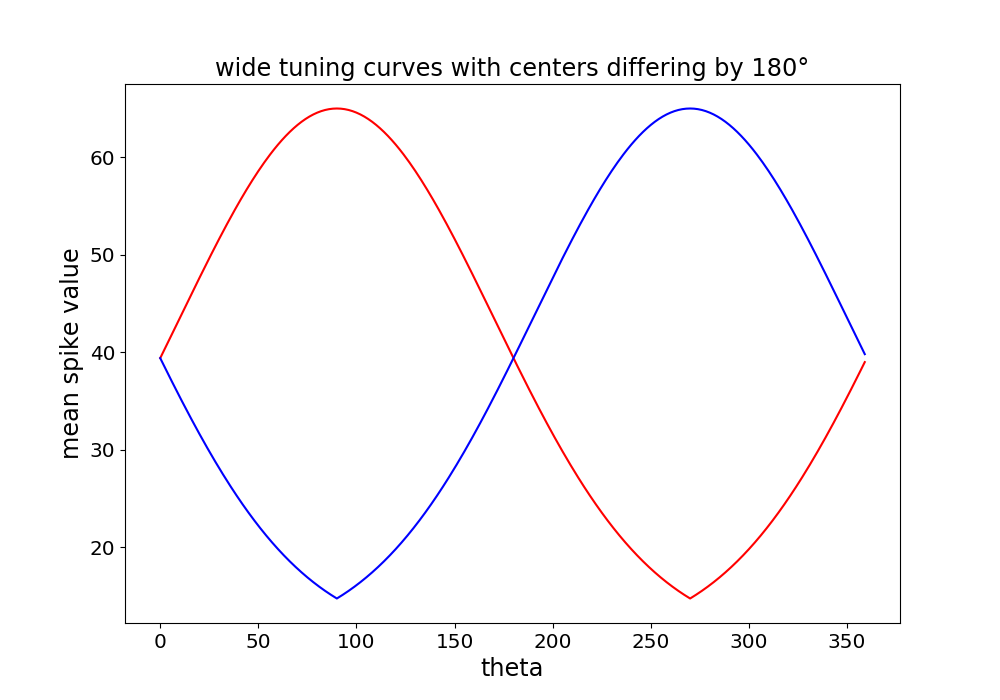

In [14]:
from itertools import product

d=90
theta_1,theta_2 = 180-d,180+d
# amplitude of the tuning curve in Hz
f0 = 65/0.3
#tuning curve, bell-shaped with a baseline
sigma_f = 80

def f(theta,theta_0=1000):
    if theta_0==1000:
        theta_0 = d
    
    if theta_0 > 180 :
        if theta >= theta_0-180:
            return f0*(0.84*np.exp(-(theta-theta_0)**2 / (2 * sigma_f**2)) +0.16)
        else :
            return f0*(0.84*np.exp(-(theta-theta_0+360)**2 / (2 * sigma_f**2)) +0.16)
    else :
        if theta <= theta_0+180:
            return f0*(0.84*np.exp(-(theta-theta_0)**2 / (2 * sigma_f**2)) +0.16)
        else :
            return f0*(0.84*np.exp(-(theta-theta_0-360)**2 / (2 * sigma_f**2)) +0.16)


# noise variability, starting with poisson
# return matrix of joint density probability p(n1,n2|theta), computed for all couples (n1,n2) of n_range
corr = -0.5
def joint_bivariate_poisson(lambda_1,lambda_2,n_list):
    len_n = len(n_list)
    l1 = norm(lambda_1).ppf(1-poisson(lambda_1).sf(n_list))
    l2 = norm(lambda_2).ppf(1-poisson(lambda_2).sf(n_list))
    l1[l1 > 1000] = 1000
    l2[l2 > 1000] = 1000
    #print(max(l1))
    #print(max(l2))
    return( multivariate_normal(mean=[lambda_1,lambda_2],cov=[[1, corr],[corr, 1]]).pdf(list(product(l1,l2))).reshape((len_n,len_n)) )     


proba_type = "uncorrelated"
def p_ns_theta(n_list,theta):
    if (proba_type == "correlated") :
        m = joint_bivariate_poisson(f(theta,theta_1)*time_bin,f(theta,theta_2)*time_bin,n_list)
        m[np.isnan(m)] = 0
        return(m)
    else :
        p_1 = poisson(f(theta,theta_1)*time_bin).pmf(n_list)
        p_2 = poisson(f(theta,theta_2)*time_bin).pmf(n_list)
        #m = p_1[:,None]+p_2
        m = np.dot(np.reshape(p_1,(len(p_1),1)), np.reshape(p_2,(1,len(p_2))) )
        return(m)

def compute_lookup_table():
    P_mat = np.zeros((len(n_range),len(n_range),len(theta_range)))
    for k in range(len(theta_range)):
            P = p_ns_theta(n_range,theta_range[k])
            P[P < 10**-200] = 0
            P_mat[:,:,k] = P*p_theta/(np.sum(P))
    return(P_mat)


def spec_inf_full(lookup_table):
    spec_inf_mat = -p_theta*np.log2(p_theta)*len(theta_range)*np.ones((len(n_range),len(n_range)))
    p_n = np.sum(lookup_table,axis=2)/len(theta_range)
    for i_theta in range(len(theta_range)):
        p_t_n = np.divide(lookup_table[:,:,i_theta],p_n)*p_theta
        spec_inf_mat -= - np.multiply(p_t_n,np.log2(p_t_n+10**(-20)))
    return(spec_inf_mat)

def SSI(P_mat,spec_infs,i_theta):
    SSI = np.multiply(spec_infs,P_mat[:,:,i_theta])/p_theta
    return(np.sum(SSI))

%matplotlib notebook
plt.plot(theta_range,[f(theta,theta_1)*0.3 for theta in theta_range],color='r')
plt.plot(theta_range,[f(theta,theta_2)*0.3 for theta in theta_range],color='b')
plt.title('wide tuning curves with centers differing by 180°')
plt.xlabel("theta")
plt.ylabel("mean spike value")
plt.show()

<IPython.core.display.Javascript object>


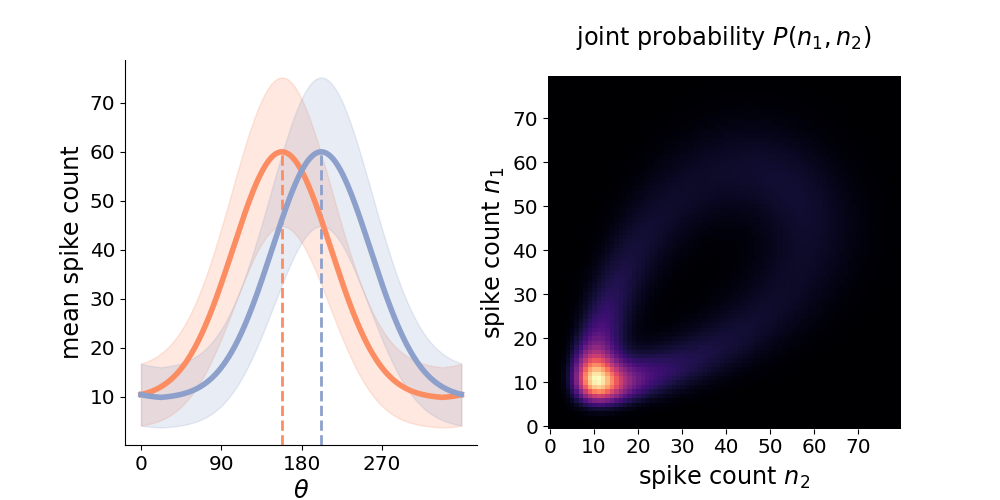

In [15]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (5, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

bmap = brewer2mpl.get_map('Set2', 'qualitative', 3)
colors = bmap.mpl_colors

fig, axs = plt.subplots(1,2,figsize=(10,5))

d = 22
theta_1,theta_2 = 180-d,180+d

sigma_f = 55
f0 = 60/ time_bin


axs[0].axvline(x=180-22,ymin=0,ymax=0.77,color=colors[1],linewidth=2,ls='--')
axs[0].axvline(x=180+22,ymin=0,ymax=0.77,color=colors[2],linewidth=2,ls='--')
axs[0].plot(theta_range,[f(theta,theta_1)*0.3 for theta in theta_range],color=colors[1],linewidth=4)
axs[0].plot(theta_range,[f(theta,theta_2)*0.3 for theta in theta_range],color=colors[2],linewidth=4)

axs[0].set_xlabel(r"$\theta$")
axs[0].set_ylabel(r"mean spike count")
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_xticks([0,90,180,270])
axs[0].set_xticklabels([0,90,180,270])


sigmas_1 = [np.sqrt(f(theta,theta_1)*time_bin) for theta in theta_range]
sigmas_2 = [np.sqrt(f(theta,theta_2)*time_bin) for theta in theta_range]


axs[0].fill_between(theta_range,[(f(theta_range[i_theta],theta_1)*time_bin-1.96*sigmas_1[i_theta]) for i_theta in range(len(theta_range))],
                                 [(f(theta_range[i_theta],theta_1)*time_bin+1.96*sigmas_1[i_theta]) for i_theta in range(len(theta_range))], 
                                 alpha=0.2, color=colors[1])

axs[0].fill_between(theta_range,[(f(theta_range[i_theta],theta_2)*time_bin-1.96*sigmas_2[i_theta]) for i_theta in range(len(theta_range))],
                                 [(f(theta_range[i_theta],theta_2)*time_bin+1.96*sigmas_2[i_theta]) for i_theta in range(len(theta_range))], 
                                 alpha=0.2, color=colors[2])


M =  compute_lookup_table()
axs[1].matshow(np.sum(M[0:80][:,0:80],axis=2),cmap='magma',origin='lower')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

axs[1].set_ylabel(r"spike count $n_1$")
axs[1].set_xlabel(r"spike count $n_2$")
axs[1].xaxis.set_ticks_position('bottom') 
axs[1].set_title(r"joint probability $P(n_1,n_2)$",pad=10)

plt.show()

## SSI of 2-neuron system

<IPython.core.display.Javascript object>


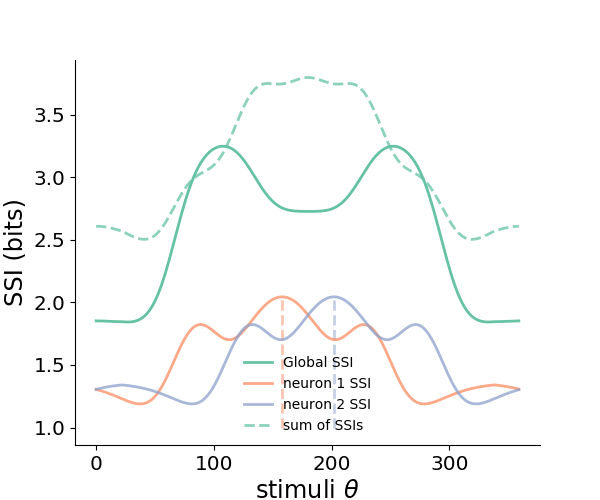

In [16]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig, axs = plt.subplots(1,1,figsize=(6,5))

si = spec_inf_full(M)
ssi = []
for i_theta in range(len(theta_range)):
    ssi.append(SSI(M,si,i_theta))

d = theta_1
ssi_1=return_SSI_1n()
d = theta_2
ssi_2=return_SSI_1n()
    
axs.plot(theta_range,ssi,color = colors[0],label="Global SSI",linewidth=2)

axs.plot(theta_range,ssi_1,color = colors[1],label="neuron 1 SSI",alpha=0.75,linewidth=2)
axs.plot(theta_range,ssi_2,color = colors[2],label="neuron 2 SSI",alpha=0.75,linewidth=2)

axs.plot(theta_range,np.sum([ssi_1,ssi_2],axis=0),'--',color = colors[0],label="sum of SSIs",alpha=0.75,linewidth=2)

axs.vlines(theta_1,1,ssi_1[theta_1],colors[1],'--',alpha=0.5,linewidth=2)
axs.vlines(theta_2,1,ssi_2[theta_2],colors[2],'--',alpha=0.5,linewidth=2)
    
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

axs.legend(frameon=False)

axs.set_ylabel("SSI (bits)")
axs.set_xlabel(r"stimuli $\theta$")
plt.show()

## Effect of correlation 

<IPython.core.display.Javascript object>


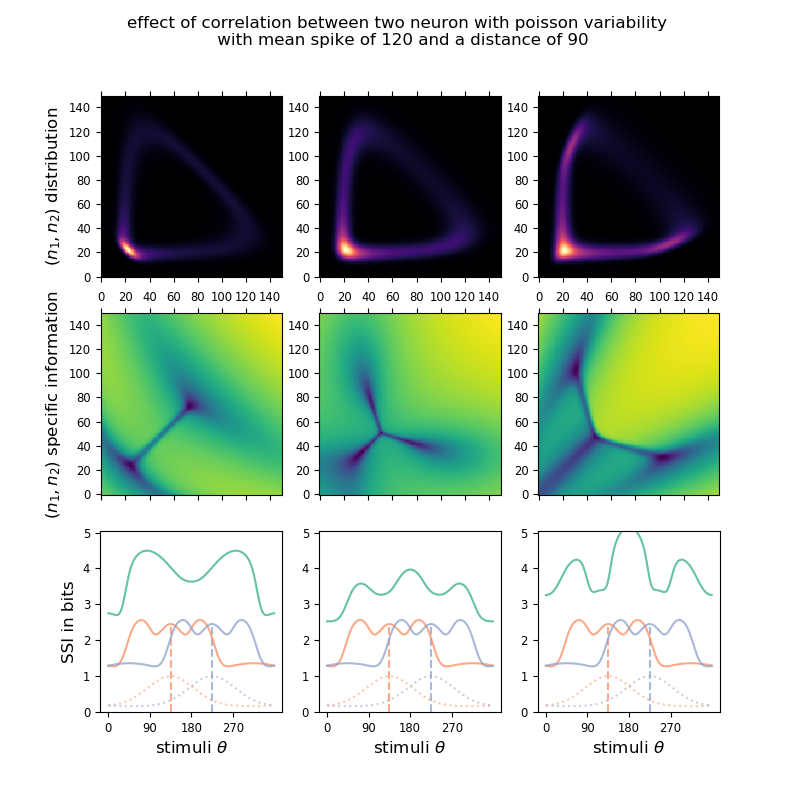

MUTUAL INFORMATION FOR CORR = -0.8 :  3.8444969350442317
MUTUAL INFORMATION FOR CORR = 0 :  3.2947819866425125
MUTUAL INFORMATION FOR CORR = 0.8 :  3.9533538497155063



In [17]:
%matplotlib notebook
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


bmap = brewer2mpl.get_map('Set2', 'qualitative', 3)
colors = bmap.mpl_colors
fig, axs = plt.subplots(3,3,figsize=(8,8))


n0 = 120
f0 = n0/0.3
sigma_f = 50
d = 45
theta_1,theta_2 = 180-d,180+d
d = theta_1
SSI_1 = return_SSI_1n()
d = theta_2
SSI_2 = return_SSI_1n()
d= 45

proba_type="correlated"
def p_ns_theta(n_list,theta):
    m = joint_bivariate_poisson(f(theta,theta_1)*time_bin,f(theta,theta_2)*time_bin,n_list)
    m[np.isnan(m)] = 0
    return(m)

correlations = [-0.8,0,0.8]
for i in tqdm(range(len(correlations))):
    corr = correlations[i]
    M =  compute_lookup_table()
    sif = spec_inf_full(M)
    ssi = []
    for i_theta in range(len(theta_range)):
        ssi.append(SSI(M,sif,i_theta))  

    im = axs[0][i].matshow(np.sum(M,axis=2),cmap='magma',origin='lower')
    im_1 = axs[1][i].matshow(sif,origin='lower')

    axs[2][i].plot(theta_range,ssi,color=colors[0])
    axs[2][i].vlines(180-d,0,SSI_1[180-d],colors=colors[1],ls='--',alpha=0.75)
    axs[2][i].vlines(180+d,0,SSI_2[180+d],color = colors[2],ls='--',alpha=0.75)
    axs[2][i].plot(theta_range,SSI_1,color = colors[1],alpha=0.75)
    axs[2][i].plot(theta_range,SSI_2,color = colors[2],alpha=0.75)
    
    axs[2,i].plot(theta_range,[f(theta,theta_1)/f0 for theta in theta_range],color=colors[1],label="Tuning curve 1",ls=':',alpha=0.5)
    axs[2,i].plot(theta_range,[f(theta,theta_2)/f0 for theta in theta_range],color=colors[2],label="Tuning curve 2",ls=':',alpha=0.5)
    
    axs[2,i].set_xticks([0,90,180,270])
    axs[2,i].set_xticklabels([0,90,180,270])
    axs[2,i].set_xlabel(r"stimuli $\theta$")
    
    print("MUTUAL INFORMATION FOR CORR =",corr,": ",np.mean(ssi))
    
axs[0][0].set_ylabel(r"$(n_1,n_2)$ distribution")
axs[1][0].set_ylabel(r"$(n_1,n_2)$ specific information")
axs[2][0].set_ylabel("SSI in bits")
axs[2][0].set_ylim(0,5.05)
axs[2][1].set_ylim(0,5.05)
axs[2][2].set_ylim(0,5.05)

plt.setp(axs[0][0].get_xticklabels(), visible=False)
plt.setp(axs[0][1].get_xticklabels(), visible=False)
plt.setp(axs[0][2].get_xticklabels(), visible=False)

fig.suptitle("effect of correlation between two neuron with poisson variability \n with mean spike of "+str(n0)+" and a distance of "+str(2*d))
plt.show()
